In [15]:
!open .

In [16]:
import pandas as pd
import NeoQuant as nq
import requests
import math

## get all company list

In [17]:
companies = nq.get_all_company_list()
companies.index = 'A' + companies.index

## bond spread

In [18]:
# https://www.kisrating.co.kr/ratingsStatistics/statics_spread.do
expected_ratio = 7.91

## load basic dataframe from excel

In [19]:
basic_df = pd.read_excel(r'data/basic_data.xlsx')
basic_df.index = basic_df[basic_df.columns[0]]
basic_df.index.name = ''
basic_df.drop(basic_df.columns[0], axis = 1, inplace = True)

## load fr dataframe from excel

In [20]:
fr_df = pd.read_excel(r'data/fr_data.xlsx')
fr_df.index = fr_df[fr_df.columns[0]]
fr_df.index.name = ''
fr_df.drop(fr_df.columns[0], axis = 1, inplace = True)
big_col = list(fr_df.columns)
small_col = list(fr_df.iloc[0])

new_big_col = []
for num, col in enumerate(big_col):
    if 'Unnamed' in col:
        new_big_col.append(new_big_col[num-1])
    else:
        new_big_col.append(big_col[num])

fr_df.columns = [new_big_col, small_col]
fr_df = fr_df.loc[ fr_df.index.dropna() ]

In [14]:
company_name_list = ['DB금융투자', 'KTB투자증권', '대신증권']

In [23]:
company_code_list = []
for name in company_name_list:
    company_code = nq.get_company_code(name, companies)
    company_code_list.append(company_code)
company_code_list

['A016610', 'A030210', 'A003540']

In [26]:
sector_df = basic_df.loc[company_code_list]

## calculate adequate price

In [29]:
total = len(sector_df)

for num, code in enumerate(sector_df.index):
    company_name = nq.get_company_name(code, companies)
    print(str(num + 1) + ' / ' + str(total) + " : " + company_name + ' (' + str(code) + ')')

#     print(num, code, company_name)
    for col in reversed(fr_df.columns.levels[0]):
#         print(fr_df[col]['ROE'])
        try:
            roe = pd.to_numeric(fr_df.loc[code][col]['ROE'])
            per = pd.to_numeric(fr_df.loc[code][col]['PER'])
            pbr = pd.to_numeric(fr_df.loc[code][col]['PBR'])
            asset = pd.to_numeric(fr_df.loc[code][col]['지배주주지분']) * 100000000
            debt_rate = pd.to_numeric(fr_df.loc[code][col]['부채비율'])
            keep_rate = pd.to_numeric(fr_df.loc[code][col]['유보율'])
            interest_rate = pd.to_numeric(fr_df.loc[code][col]['배당수익률'])

                
            if not math.isnan(roe) and not math.isnan(asset):
                print('standard date : ' + col)
                stock_count = sector_df.loc[code]['주식수']
                sector_df.at[code, '기준일'] = col
                sector_df.at[code, 'roe'] = roe
                sector_df.at[code, 'per'] = per
                sector_df.at[code, 'pbr'] = pbr
                sector_df.at[code, '부채비율'] = debt_rate
                sector_df.at[code, '유보율'] = keep_rate
                sector_df.at[code, '배당수익률'] = interest_rate
                
                sector_df.at[code, 'expectation'] = expected_ratio
    #             print('stock_count : ' + str(stock_count))
                high = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 1)
    #             print('high : ' + str(high))
                sector_df.at[code, 'high'] = high
                middle = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
                sector_df.at[code, 'middle'] = middle
                low = nq.get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)
                sector_df.at[code, 'low'] = low
                break
        except ValueError:
            print('>>> ValueError')
            continue


sector_df['dis_rate'] = sector_df['price'] / sector_df['low']
sector_df = sector_df.sort_values(by='dis_rate', ascending=True)
sector_df['rank'] = sector_df['dis_rate'].rank()

1 / 3 : DB금융투자 (A016610)
standard date : 2019/12
2 / 3 : KTB투자증권 (A030210)
standard date : 2019/12
3 / 3 : 대신증권 (A003540)
standard date : 2019/12


In [35]:
sector_df

,총주식수,자사주,주식수,price,외국인,시가총액,name,기준일,roe,per,pbr,부채비율,유보율,배당수익률,expectation,high,middle,low,dis_rate,rank
,,,,,,,,,,,,,,,,,,,,
A016610,42446389,1017500,41428889,6080,8.22,258100000000,DB금융투자,2019/12,7.15,3.70,0.25,937.78,233.24,5.90,7.91,15737.0,16205.0,16469.0,0.369178,1.0
A030210,67169262,1275813,65893449,4450,22.52,268400000000,KTB투자증권,2019/12,9.18,3.30,0.29,392.65,61.97,6.40,7.91,9753.0,9293.0,9047.0,0.491876,2.0
A003540,86773400,14591441,72181959,13850,19.47,703200000000,대신증권,2019/12,4.79,10.95,0.47,863.65,407.51,8.37,7.91,20502.0,23170.0,24778.0,0.558964,3.0


## show chart

In [32]:
company_code_list = sector_df.index

In [33]:
company_code_list

Index(['A016610', 'A030210', 'A003540'], dtype='object', name='')

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


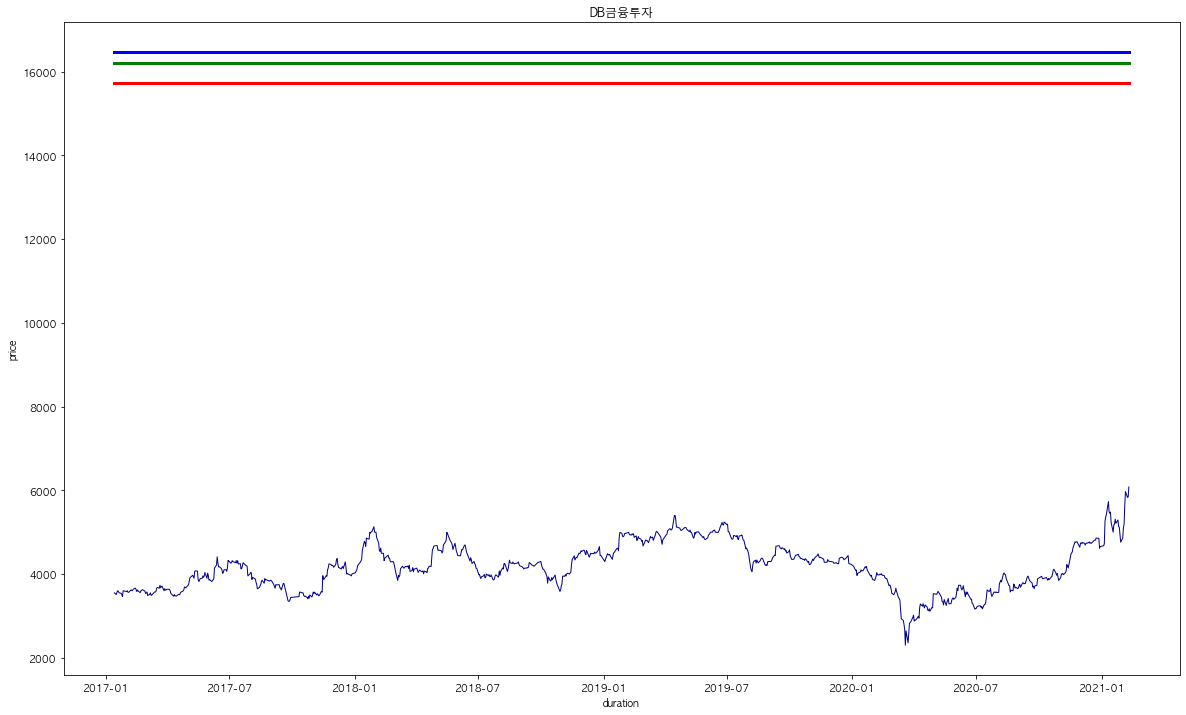

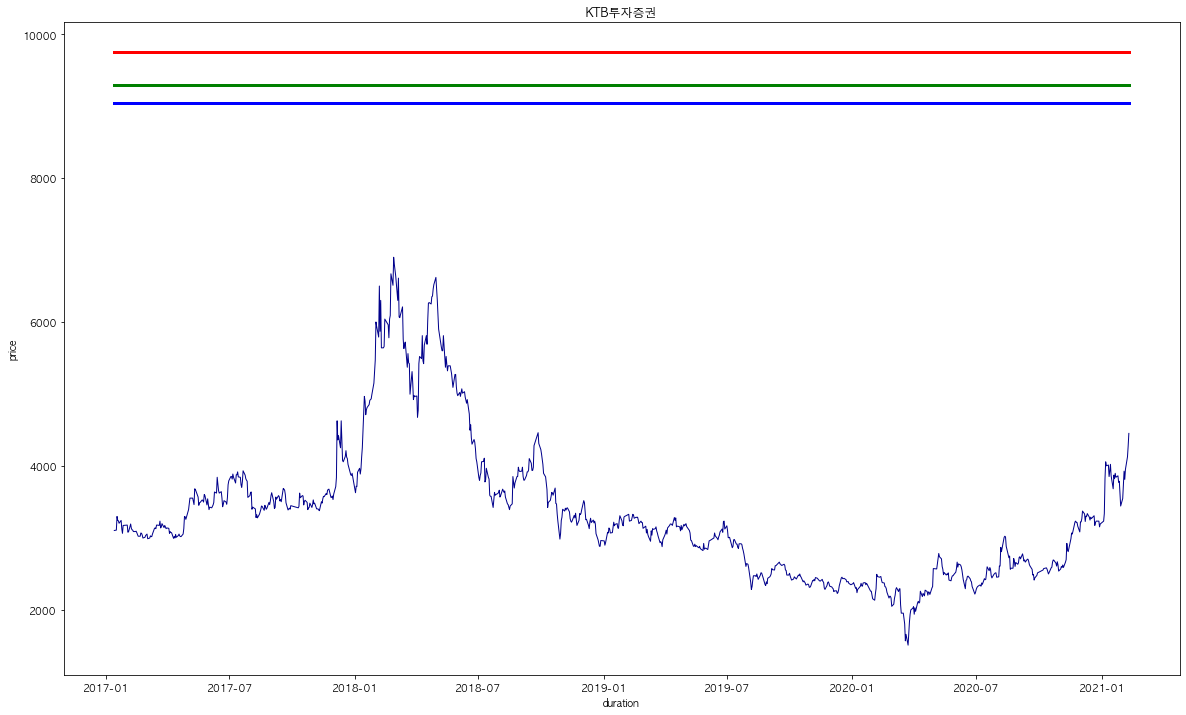

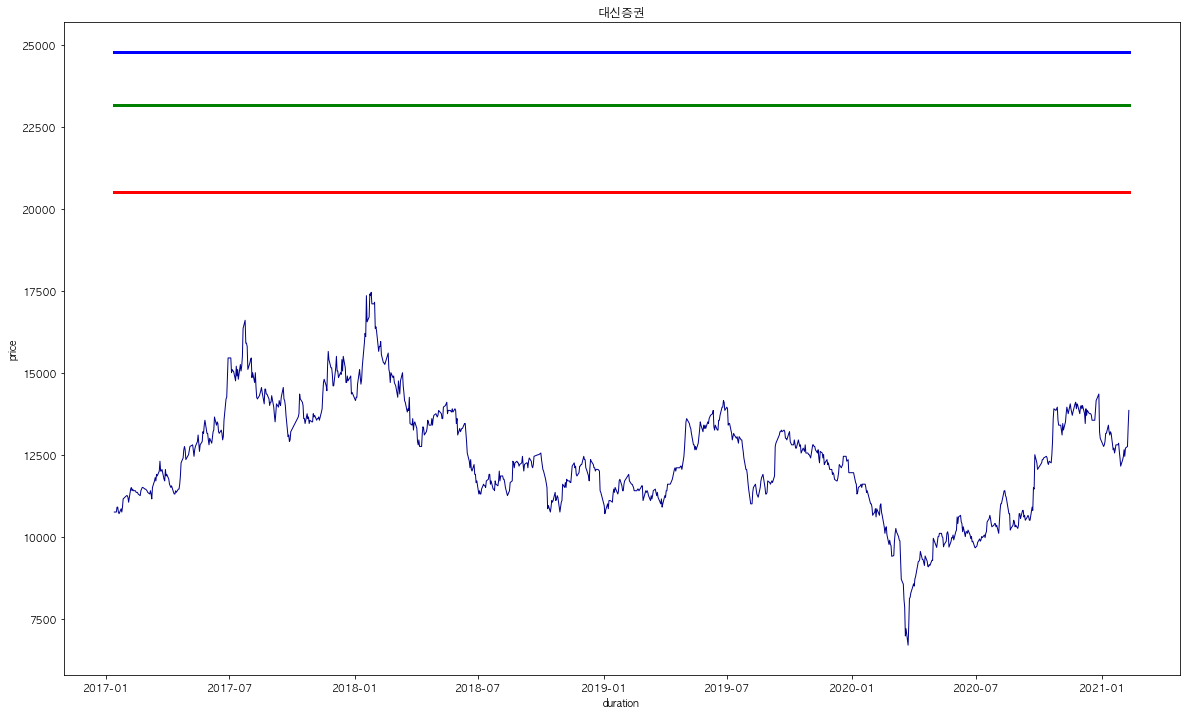

In [34]:
for company_code in company_code_list:
    company_name = nq.get_company_name(company_code, companies)

    price_df = nq.request_price_list(company_code, 'day', 1000)

    price_high = sector_df.loc[company_code]['high']
    price_middle = sector_df.loc[company_code]['middle']
    price_low = sector_df.loc[company_code]['low']

    price_df['price_low'] = [price_low] * len(price_df)
    price_df['price_middle'] = [price_middle] * len(price_df)
    price_df['price_high'] = [price_high] * len(price_df)

    nq.show_price_chart(company_code, company_name, price_df)